# Using https://youtu.be/u1loyDCoGbE for implementation of U-net : https://arxiv.org/pdf/1505.04597.pdf

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import glob
import cv2 as cv

In [3]:
# #Google Collab specifics
# from google.colab import drive
# drive.mount('/content/drive')
# !cp "/content/drive/MyDrive/helpers.py" .
# imgs_names = glob.glob( '/content/drive/MyDrive/th_analysedimages/*.tif')
# labels_names = glob.glob('/content/drive/MyDrive/labels/*.png')

In [8]:
#Local github project specifics
imgs_names = glob.glob( './th_analysedimages/*.tif')
labels_names = glob.glob('./th_csv_labels/png_masks_emb/*.png')

In [16]:
imgs_names= sorted(imgs_names)
#imgs = [cv.imread(name, cv.IMREAD_UNCHANGED) for name in imgs_names[1]]
print(f"Found {len(imgs_names)} images")

labels_names= sorted(labels_names)
#labels = [png_to_mask(cv.imread(name, cv.IMREAD_UNCHANGED)) for name in labels_names]
print(f"Found {len(labels_names)} labels")

Found 357 images
Found 357 labels


In [13]:
from helpers import *

<img src="./U-Net structure.png" width="500">

In [92]:
# UNet definitions
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        # functions for going down the U
        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.d_double_conv_1 = double_conv(1, 64)
        self.d_double_conv_2 = double_conv(64, 128)
        self.d_double_conv_3 = double_conv(128, 256)
        self.d_double_conv_4 = double_conv(256, 512)
        self.d_double_conv_5 = double_conv(512, 1024)
        
        # functions for going up the U
        self.up_trans_4 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2)        
        self.u_double_conv_4 = double_conv(1024, 512)
        self.up_trans_3 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2)
        self.u_double_conv_3 = double_conv(512, 256)
        self.up_trans_2 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)
        self.u_double_conv_2 = double_conv(256, 128)
        self.up_trans_1 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)
        self.u_double_conv_1 = double_conv(128, 64)
        
        self.out = nn.Conv2d(in_channels=64, out_channels=2, kernel_size=1)
        
    def forward(self, image):
        '''makes the 388x388 prediction with the model, image must be 572x572pixels'''
        
        # Going down the U
        d1 = self.d_double_conv_1(image) # first "level"
        # print(x1.size())
        x = self.max_pool_2x2(d1)
        d2 = self.d_double_conv_2(x) # second
        x = self.max_pool_2x2(d2)
        d3 = self.d_double_conv_3(x) # third
        x = self.max_pool_2x2(d3)
        d4 = self.d_double_conv_4(x) # fourth
        x = self.max_pool_2x2(d4)
        x = self.d_double_conv_5(x) # last layer (fifth) : no max pool
        # plt.imshow(x.detach().numpy()[0, 0, :, :])
        
        # Going up the U
        x = self.up_trans_4(x)
        d4 = crop_img(tensor=d4, target_tensor=x) #crop to copy
        x = self.u_double_conv_4(torch.cat([d4, x], 1))
        
        x = self.up_trans_3(x)
        d3 = crop_img(tensor=d3, target_tensor=x)
        x = self.u_double_conv_3(torch.cat([d3, x], 1))
        
        x = self.up_trans_2(x)
        d2 = crop_img(tensor=d2, target_tensor=x)
        x = self.u_double_conv_2(torch.cat([d2, x], 1))
        
        x = self.up_trans_1(x)
        d1 = crop_img(tensor=d1, target_tensor=x)
        x = self.u_double_conv_1(torch.cat([d1, x], 1))
        
        x = self.out(x)
        return x
        
        
    
# some functions so reduce redunduncy
def double_conv(nb_in_channels, nb_out_channels):
    conv = nn.Sequential(
        nn.Conv2d(nb_in_channels, nb_out_channels, kernel_size=3),
        nn.ReLU(inplace=True),
        nn.Conv2d(nb_out_channels, nb_out_channels, kernel_size=3),
        nn.ReLU(inplace=True),
    )
    return conv

def crop_img(tensor, target_tensor):
    target_size = target_tensor.size()[2] # NB they are square so .size[2]=.size[3]
    tensor_size = tensor.size()[2]
    delta = tensor_size - target_size #target is always smaller
    pix_crop = delta // 2
    return tensor[:, :, pix_crop:tensor_size-pix_crop, pix_crop:tensor_size-pix_crop]

0.023851668
0.12115492


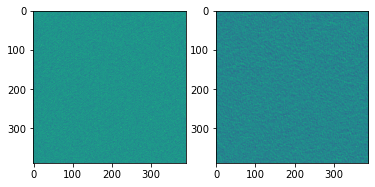

In [99]:
# Test forward to see how it behaves
image = torch.rand((1, 1, 572, 572))
model = UNet()
y = model(image).detach().numpy()
print(y[0,0, :, :].max())
print(y[0,1, :, :].max())
_ , axs = plt.subplots(ncols=2)
axs[0].imshow(y[0,0, :, :])
axs[1].imshow(y[0,1, :, :])
plt.show()

In [ ]:
# Training function
def train_model(model, img_names, label_names, num_epoch):
    # If a GPU is available (Colab)
    if not torch.cuda.is_available():
        raise Exception("Things will go much quicker if you enable a GPU in Colab under 'Runtime / Change Runtime Type'")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")